In [116]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

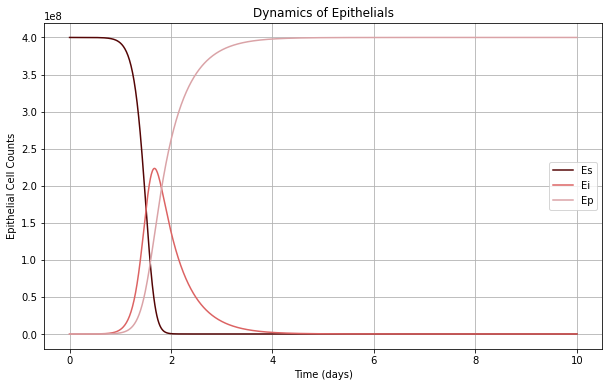

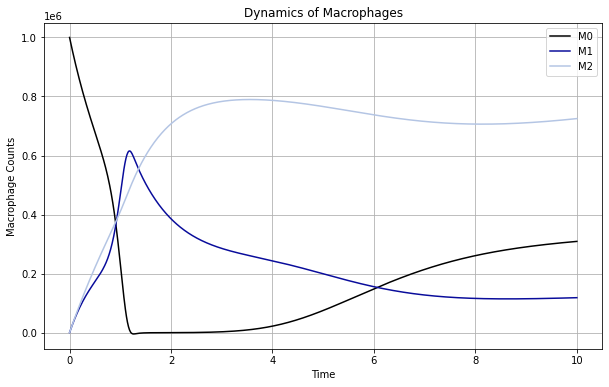

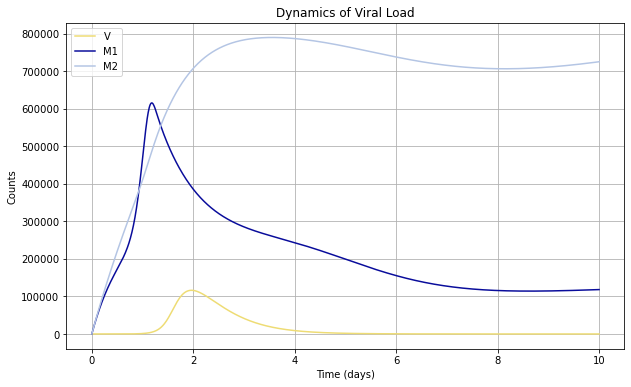

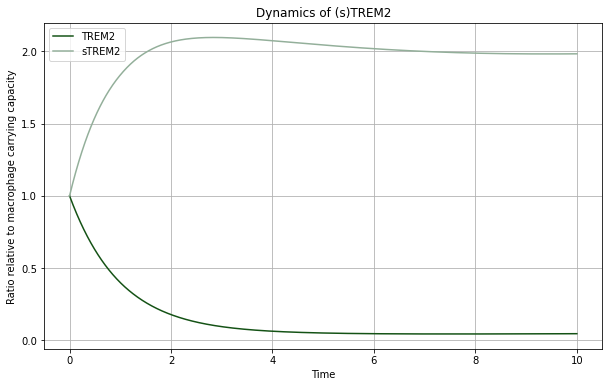

In [200]:
## USE THIS ONE ### 


def big_kahuna(variables, t, beta, gamma, n_epithelial, g, s1, K, decay, nu_01, nu_02,nu_10, nu_20, p, c, kappa_M1, kappa_M2, clevage, recM0, recM1, recM2, sTREM2_0, degradation):
    
    Es, Ei, Ep, M0, M1, M2, V, TREM2, sTREM2 = variables
    
    ## ENDOTHELIAL ##
    N = Es + Ei + Ep 
    #dEsdt = n_epithelial - beta * Es * Ei / N
    #dEidt = beta * Es * Ei / N - gamma * Ei
    #dEpdt = gamma * Ei
    
    dEsdt = n_epithelial - beta * Es * V
    dEidt = beta * Es * V - gamma * Ei
    dEpdt = gamma * Ei
    
    
    ## MACROPHAGE ## 
    
    # s1  = effectiveness of M2 attenuates M to M1 
    # s2 = effectiveness of M1 promotes M to M2 
    
    s2 = sTREM2 / sTREM2_0 # sTREM2_0 = 1 so this is really just sTREM2
    
    
    dM0dt = M0* (      g*(1 - ((M0 + M1 + M2) / K)) - ( nu_01 / (1 + s1*(M2/M0)) ) - (nu_02*(1 + s2*(M1/M0)))    ) + nu_20*M2 + nu_10*M1 - q1*Ei*M0 - q2*V*M0 
    
    # M1
    dM1dt = M0* (( nu_01/(1 + s1*(M2/M0))) + q1*Ei +q2*V ) - nu_10*M1 - decay*M1 
    
    # M2
    dM2dt = nu_02*(1 + s2*(M1/M0))*M0 - nu_20*M2 - decay*M2
    
    
    ## VIRAL LOAD ##
    dVdt = p*Ei - c*V - kappa_M1*M1*V 
    
    
    
    
    ## (s)TREM2 ## 
    
    # TREM2 
    dTREM2dt = (M0*recM0 / K)*( 1 - shed_M0) + (M1*recM1 / K)*(1 - shed_M1) + (M2*recM2 / K)*(1 - shed_M2) -cleavage*TREM2
    
    # sTREM2 
    dsTREM2dt = cleavage*TREM2 + sTREM2_0 + (M0*recM0/ K) *shed_M0 + (M1*recM1 / K) *shed_M1 + (M2*recM2 / K) *shed_M2 - degradation*sTREM2
    
    
    return [dEsdt, dEidt, dEpdt, dM0dt, dM1dt, dM2dt, dVdt, dTREM2dt, dsTREM2dt] 

# enthothelial parameters
beta = 1.31*1e-4  # Infection rate
gamma = 2.1       # Recovery rate
# N = 4e8         # Total population - this is inconsistent with the initial conditions
n_epithelial = 0  # Rate of susceptible epithelial cells introduction

#viral parameters 
p = 2.2 * 1e-3         # viral production rate, virions / day 
c = 1                  # viral natural death rate, 1 / day
kappa_M1 = 4.6*1e-6    # rate of viral internalization by M1, virions / day 
kappa_M2 = 2.3*1e-6    # rate of viral internalization by M2, virions / day 



# macrophage params 
g = 0.2           # regrowth rate 
s1 = 1            # effectiveness at M0 -> M1 attenuation 
#s2 = 20            # effectiveness at M0 -> M2 promotion 
K = 10e6          # macrophage carrying capacity 
decay = 0.02      # decay rate of M1 and M2 
nu_01 = 0.5       # conversion rate M0 -> M1
nu_02 = 0.5       # conversio rate M0 -> M2
nu_10 = 0.33      # conversion rate M1 -> M0
nu_20 = 0.33      # conversion rate M2 -> M0
q1 = 1e-6         # rate of infected cell conversion from M0 -> M1
q2 = 1e-6         # rate of virus induced conversion from M0 -> M1
#V = 0.33          # initial viral load 
Ei0 = 200         # initial value of infected cells (same as Ei0)

# (s)TREM2 params 
cleavage = 0.99
recM0 = 1
recM1 = 1.5
recM2 = 2
shed_M0 = 0.6
shed_M1 = 0.7
shed_M2 = 0.8
degradation = 0.6


# Initial conditions
Es0 = 4e8         # Initial susceptible epithelial cells
#Ei0 = 200        # Initial infected epithelial cells
Ep0 = 0           # Initial phagocytosed epithelial cells

M0_0 = 1e6
M1_0 = 0
M2_0 = 0

V0 = 0.33    # initial viral load 
#A0 = 1e6     # initial antibody concentration 
 
TREM2_0 = recM0    # TREM2 relative to the carrying capacity, M0 / K (TREM2_n / TREM2_0)
sTREM2_0 = 1       

variables0 = [Es0, Ei0, Ep0, M0_0, M1_0, M2_0, V0, TREM2_0, sTREM2_0] 



# Time points
t = np.linspace(0, 10, 1000)

# Solve ODE
results = odeint(big_kahuna, variables0, t, args=(beta, gamma, n_epithelial, g, s1, K, decay, nu_01, nu_02,nu_10, nu_20, p, c, kappa_M1, kappa_M2, cleavage, recM0, recM1, recM2, sTREM2_0, degradation ))


# Plot epithelials
plt.figure(figsize=(10, 6))
plt.plot(t, results[:, 0], label='Es', color='#540505')
plt.plot(t, results[:, 1], label='Ei', color='#dc6363')
plt.plot(t, results[:, 2], label='Ep', color='#daa3a7')
plt.title('Dynamics of Epithelials')
plt.xlabel('Time (days)')
plt.ylabel('Epithelial Cell Counts')
plt.legend()
plt.grid(True)
plt.show()

# Plot macrophages
plt.figure(figsize=(10, 6))
plt.plot(t, results[:, 3], label='M0', color='#000000')
plt.plot(t, results[:, 4], label='M1', color='#090c9b')
plt.plot(t, results[:, 5], label='M2', color='#b4c5e4')
plt.title('Dynamics of Macrophages')
plt.xlabel('Time')
plt.ylabel('Macrophage Counts')
plt.legend()
plt.grid(True)
plt.show()

# Plot viral load vs M1 vs M2  ### TO DO put V on a different axis 
plt.figure(figsize=(10, 6))
plt.plot(t, results[:, 6], label='V', color='#EEDC74')
plt.plot(t, results[:, 4], label='M1', color='#090c9b')
plt.plot(t, results[:, 5], label='M2', color='#b4c5e4')
plt.title('Dynamics of Viral Load')
plt.xlabel('Time (days)')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()


# Plot (s)TREM2
plt.figure(figsize=(10, 6))
plt.plot(t, results[:, 7], label='TREM2', color='#145215')
plt.plot(t, results[:, 8], label='sTREM2', color='#93af9a')
plt.title('Dynamics of (s)TREM2')
plt.xlabel('Time')
plt.ylabel('Ratio relative to macrophage carrying capacity')
plt.legend()
plt.grid(True)
plt.show()



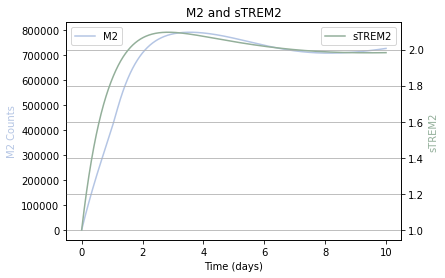

In [201]:
# Plot sTREM2, Ep, M2

fig, ax1 = plt.subplots()

ax1.plot(t, results[:, 5], label='M2', color='#b4c5e4')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('M2 Counts', color='#b4c5e4')


#ax1.plot(t, results[:, 2], label='Ep', color='#daa3a7')


ax2 = ax1.twinx()

ax2.plot(t, results[:, 8], label='sTREM2', color='#93af9a')
ax2.set_ylabel('sTREM2', color='#93af9a')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.title('M2 and sTREM2')
plt.show()

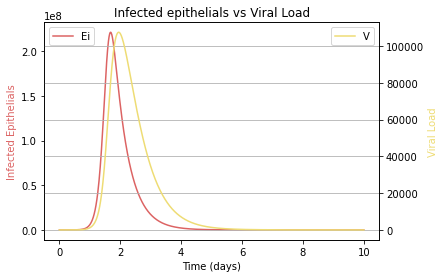

In [126]:
# Plot Ei vs viral load

fig, ax1 = plt.subplots()

ax1.plot(t, results[:, 1], label='Ei', color='#dc6363')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infected Epithelials', color='#dc6363')


ax2 = ax1.twinx()

# viral load 
ax2.plot(t, results[:, 6], label='V', color='#EEDC74')
ax2.set_ylabel('Viral Load', color='#EEDC74')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.title('Infected epithelials vs Viral Load')
plt.show()





## Sensitivity Analysis 

In [196]:
BK_parameters = [beta, 
                 gamma, 
                 n_epithelial,
                 g,
                 s1,
                 K,
                 decay, 
                 nu_01,
                 nu_02,
                 nu_10,
                 nu_20,
                 p,
                 c,
                 kappa_M1,
                 kappa_M2,
                 cleavage,
                 recM0,
                 recM1,
                 recM2,
                 sTREM2_0,
                 degradation]


def approx_steady_state(list):
    last_100 = list[-100:]
    steady_state_value = sum(last_100) / 100
    
    return steady_state_value


def calculate_sensitivity_BK(params, epsilon=1e-6):
    
    # approximate steady state solutions 
    Es_steady = approx_steady_state(results[:, 0])
    Ei_steady = approx_steady_state(results[:, 1])
    Ep_steady = approx_steady_state(results[:, 2])
    M0_steady = approx_steady_state(results[:, 3])
    M1_steady = approx_steady_state(results[:, 4])
    M2_steady = approx_steady_state(results[:, 5])
    V_steady = approx_steady_state(results[:, 6])
    TREM2_steady = approx_steady_state(results[:, 7]) # TREM2 does not appear to reach steady state 
    sTREM2_steady = approx_steady_state(results[:, 8])
    
    
    num_params = len(params)
    sensitivity = np.zeros(num_params)
    
    for i in range(num_params):
        # Perturb parameter by epsilon
        params_perturbed = np.array(params)
        
        params_perturbed[i] += epsilon
        
        results_perturbed = odeint(big_kahuna, variables0, t, args=(params_perturbed[0],  # beta, 
                                                              params_perturbed[1],  # gamma, 
                                                              params_perturbed[2],  # n_epithelial, 
                                                              params_perturbed[3],  # g,
                                                              params_perturbed[4],  # s1, 
                                                              params_perturbed[5], # K, 
                                                              params_perturbed[6], # decay,
                                                              params_perturbed[7], # nu_01,
                                                              params_perturbed[8], # nu_02,
                                                              params_perturbed[9], # nu_10, 
                                                              params_perturbed[10], # nu_20, 
                                                              params_perturbed[11], # p, 
                                                              params_perturbed[12], # c, 
                                                              params_perturbed[13], # kappa_M1,
                                                              params_perturbed[14], # kappa_M2, 
                                                              params_perturbed[15], # clevage      
                                                              params_perturbed[16], # recM0, 
                                                              params_perturbed[17], # recM1, 
                                                              params_perturbed[18], # recM2,
                                                              params_perturbed[19], # sTREM2_0, 
                                                              params_perturbed[20] ) # degradation ))
                            ) 
        
        Es_ss_perturbed = approx_steady_state(results_perturbed[:, 0])
        Ei_ss_perturbed = approx_steady_state(results_perturbed[:, 1])
        Ep_ss_perturbed = approx_steady_state(results_perturbed[:, 2])
        M0_ss_perturbed = approx_steady_state(results_perturbed[:, 3])
        M1_ss_perturbed = approx_steady_state(results_perturbed[:, 4])
        M2_ss_perturbed = approx_steady_state(results_perturbed[:, 5])
        V_ss_perturbed = approx_steady_state(results_perturbed[:, 6])
        TREM2_ss_perturbed = approx_steady_state(results_perturbed[:, 7])
        sTREM2_ss_perturbed = approx_steady_state(results_perturbed[:, 8])
            
            
        delta_Ep = Ep_ss_perturbed - Ep_steady
        delta_M0 = M0_ss_perturbed - M0_steady 

        # Calculate sensitivity coefficient
        sensitivity[i] = delta_Ep / epsilon
        
    return sensitivity

In [197]:
test = calculate_sensitivity_BK(BK_parameters)

print(test)

[ 4.61778402e+05  1.75237656e+02  5.18560410e+00 -8.52346420e+00
  2.38418579e-01  2.98023224e-01  1.75833702e+01 -1.37090683e+00
  2.30669975e+01  2.38418579e-01 -1.13844872e+01  2.59176493e+04
 -9.00030136e+00 -9.03813970e+06  0.00000000e+00  0.00000000e+00
  1.43051147e+00  2.38418579e-01  9.53674316e-01 -3.75509262e+00
 -6.67572021e+00]


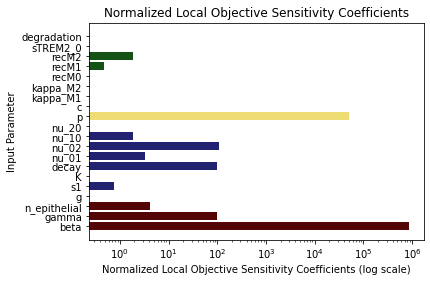

In [180]:
test = calculate_sensitivity_BK(BK_parameters)

BK_param_names = ['beta', 
                 'gamma', 
                 'n_epithelial',
                 'g',
                 's1',
                 'K',
                 'decay', 
                 'nu_01',
                 'nu_02',
                 'nu_10',
                 'nu_20',
                 'p',
                 'c',
                 'kappa_M1',
                 'kappa_M2',
                 'recM0',
                 'recM1',
                 'recM2',
                 'sTREM2_0',
                 'degradation']

color_by_category = ['#540505',
                    '#540505',
                    '#540505',
                    '#232270',
                    '#232270',
                    '#232270',
                    '#232270',
                    '#232270',
                    '#232270',
                    '#232270',
                    '#232270',
                    '#eedc74',
                    '#eedc74',
                    '#eedc74',
                    '#eedc74',
                    '#145215',
                     '#145215',
                     '#145215',
                     '#145215',
                     '#145215',
                    ]



coefficients = [ 8.45382333e+05,  9.84668732e+01,  4.11272049e+00, -3.90410423e+01,
  7.74860382e-01, -4.76837158e-01,  9.95397568e+01,  3.33786011e+00,
  1.07884407e+02,  1.84774399e+00, -6.24060631e+01,  5.10542989e+04,
 -3.46899033e+01, -4.95000733e+07,  0.00000000e+00, -5.96046448e-01,
  4.76837158e-01,  1.90734863e+00, -1.49011612e+01, -3.76701355e+01]



plt.barh(range(len(coefficients)), coefficients, color=color_by_category)

#for i, value in enumerate(coefficients):
 #   plt.text(value, i, f'{value:.2e}', va='center', ha='left', fontsize=8)


plt.xlabel('Normalized Local Objective Sensitivity Coefficients (log scale)')
plt.ylabel('Input Parameter')
plt.title('Normalized Local Objective Sensitivity Coefficients')

# Set logarithmic scale for x-axis
plt.xscale('log')

plt.yticks(range(len(BK_parameters)), BK_param_names)

plt.show()